# Обучение головы (FFN) на эмбеддингах

Если запускаете, полностью клонировав репозиторий локально

In [1]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

Если используете блокнот независимо от проекта

In [ ]:
! pip install --upgrade git+https://github.com/rimgro/biocadprotein.git
clear_output()

Импорт библиотек

In [38]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split

from fpgen.prop_prediction.dataset import FPbase
from fpgen.prop_prediction.metrics import (
    get_regression_metrics,
    get_classification_metrics
)

In [191]:
import random
import numpy as np

SEED = 52

np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)
torch.cuda.manual_seed(SEED)

## Подготовка данных

In [2]:
def preproc(line):
    clean_line = line.replace('\n', ' ').strip('[]')
    numbers = np.fromstring(clean_line, sep=' ')

    return numbers

In [3]:
dataset = FPbase('../data/dataset_embedd.csv', preprocess_function=preproc)
dataset.to_train_dataframe().head()

,sequence,brightness,em_max,ex_max,ext_coeff,lifetime,maturation,pka,stokes_shift,qy,agg,switch_type
0,"[-0.00530367903, 0.00854283385, 0.00128412445,...",-0.516789,-1.357357,-1.875798,-0.814071,NaN,NaN,0.323540,0.923046,-0.056729,m,b
1,"[-0.00167965586, 0.00413581124, 0.00335621182,...",-0.802832,-0.408006,-0.214689,-1.192834,NaN,NaN,1.878962,-0.403015,-0.465539,NaN,b
2,"[-0.00447917636, -0.00560046919, 0.00733367307...",-1.040228,0.883734,0.758032,-0.257845,NaN,NaN,NaN,0.074367,-1.725418,NaN,b
3,"[-0.00244280021, 0.0043460303, 0.00649108412, ...",NaN,-0.516948,-0.184759,NaN,NaN,NaN,NaN,-0.641706,NaN,m,b
4,"[-0.00111842179, -0.00419556629, 0.00596778374...",NaN,-0.610327,-0.244619,NaN,NaN,NaN,NaN,-0.694749,NaN,t,b


## Обучение модели

In [211]:
TARGET = 'em_max'
NUM_EPOCHS = 500
BATCH_SIZE = 32
LEARNING_RATE = 5e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [214]:
class FNNRegressor(nn.Module):
    def __init__(self, input_size, hidden_sizes=[128, 64, 32], dropout_rate=0.2):
        super().__init__()
        layers = []
        last_size = input_size

        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(last_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            last_size = hidden_size
            
        layers.append(nn.Linear(last_size, 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x).squeeze(1)

In [215]:
x_series, y_series = dataset.get_train(TARGET, is_scaled=True)

x = np.vstack(x_series.values)
y = y_series.values

In [216]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.1, random_state=52)

train_dataset = TensorDataset(torch.tensor(x_train, dtype=torch.float32),
                              torch.tensor(y_train, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(x_val, dtype=torch.float32),
                            torch.tensor(y_val, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

In [217]:
model = FNNRegressor(input_size=x.shape[1], hidden_sizes=[128, 64, 32], dropout_rate=0.2).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.MSELoss()

In [218]:
# Инициализация списков для сохранения метрик
train_losses = []
val_losses = []

In [219]:
for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0

    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)

    avg_loss = total_loss / len(train_loader.dataset)
    train_losses.append(avg_loss)

    # Валидация
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for xb_val, yb_val in val_loader:  # Предполагаем, что у вас есть val_loader
            xb_val, yb_val = xb_val.to(DEVICE), yb_val.to(DEVICE)
            pred_val = model(xb_val)
            val_loss = loss_fn(pred_val, yb_val)
            total_val_loss += val_loss.item() * xb_val.size(0)
    
    avg_val_loss = total_val_loss / len(val_loader.dataset)
    val_losses.append(avg_val_loss)

    # Конечная валидация
    if (epoch + 1) % 25 == 0:
        model.eval()
        with torch.no_grad():
            y_pred = model(torch.Tensor(x_val).to('cuda'))

        metrics = get_regression_metrics(
            y_pred=dataset.rescale_targets(y_pred.cpu(), TARGET),
            y_true=dataset.rescale_targets(y_val, TARGET)
        )
        
        print(f"Epoch {epoch+1:3d} | Loss: {avg_loss:.4f} | Metrics: {metrics}")

Epoch  25 | Loss: 0.3569 | Metrics: {'rmse': 44.94356212560208, 'mae': 30.054927415114182, 'r2': 0.5614127110844931, 'mae_median': 21.166412353515625}
Epoch  50 | Loss: 0.2858 | Metrics: {'rmse': 41.356656044268, 'mae': 27.429840557391827, 'r2': 0.6286256612992956, 'mae_median': 21.5643310546875}
Epoch  75 | Loss: 0.2037 | Metrics: {'rmse': 41.75392204359523, 'mae': 26.385496638371393, 'r2': 0.6214566583426102, 'mae_median': 15.352783203125}
Epoch 100 | Loss: 0.1883 | Metrics: {'rmse': 41.74161590937935, 'mae': 26.364584585336537, 'r2': 0.6216797616323171, 'mae_median': 15.6654052734375}
Epoch 125 | Loss: 0.1727 | Metrics: {'rmse': 42.02113152366479, 'mae': 26.342596905048076, 'r2': 0.6165960834886689, 'mae_median': 15.69708251953125}
Epoch 150 | Loss: 0.1742 | Metrics: {'rmse': 41.40763115509989, 'mae': 25.782063645582934, 'r2': 0.6277096048906614, 'mae_median': 15.062103271484375}
Epoch 175 | Loss: 0.1524 | Metrics: {'rmse': 40.25031919868575, 'mae': 25.666115159254808, 'r2': 0.64822

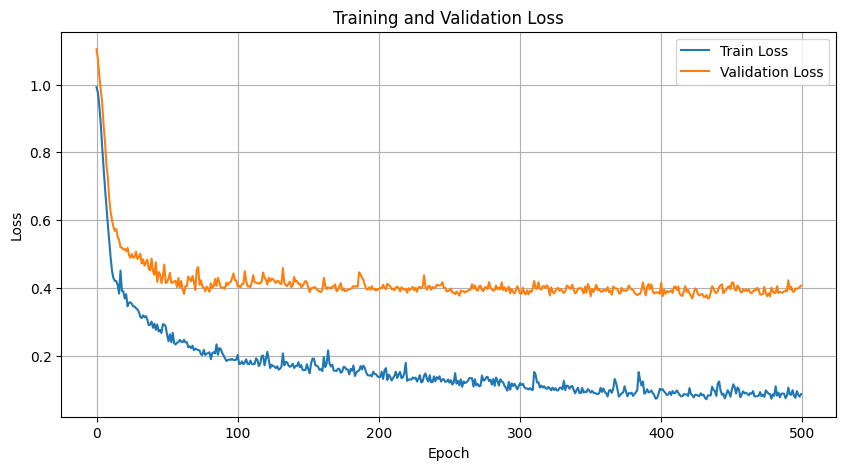

In [220]:
import matplotlib.pyplot as plt

# Построение графиков после обучения
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [221]:
x_test, y_test = dataset.get_test(TARGET)

In [222]:
model.eval()

with torch.no_grad():
    y_pred = model(torch.Tensor(x_test).to('cuda'))

# Метрики
metrics = get_regression_metrics(
    y_pred=dataset.rescale_targets(y_pred.cpu(), TARGET),
    y_true=dataset.rescale_targets(y_test, TARGET)
)
metrics

{'rmse': 31.38574886089476,
 'mae': 19.475023646554547,
 'r2': 0.7334555558270242,
 'mae_median': 10.241302490234375}

In [120]:
dataset.rescale_targets(y_pred.cpu(), TARGET)

array([[540.9174 ],
       [542.2734 ],
       [543.21643],
       [542.7924 ],
       [543.63324],
       [540.93274],
       [540.56177],
       [541.6906 ],
       [541.45917],
       [540.6969 ],
       [543.80566],
       [540.7656 ],
       [540.7676 ],
       [542.30634],
       [542.13666],
       [542.5245 ],
       [542.7165 ],
       [542.5995 ],
       [540.81726],
       [540.80005],
       [542.71216],
       [541.013  ],
       [542.717  ],
       [542.5498 ],
       [543.0807 ],
       [541.49615],
       [540.8012 ],
       [543.2963 ],
       [542.6085 ],
       [542.85736],
       [542.9008 ],
       [541.0285 ],
       [542.76056],
       [540.76587],
       [540.47363],
       [540.4094 ],
       [540.6031 ],
       [542.6645 ],
       [540.3463 ],
       [542.8618 ],
       [543.1291 ],
       [541.2821 ],
       [542.6221 ],
       [542.0935 ],
       [542.8531 ],
       [543.3548 ],
       [542.1874 ],
       [543.044  ],
       [542.85486],
       [540.938  ],
